In [2]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
file_path = 'new_Hotel_reviews_20k.csv'


In [10]:
# CSV 파일 불러오기
data = pd.read_csv(file_path)
data.drop_duplicates(inplace=True)


# data = data[(data["rating_review"] == 1) | (data["rating_review"] == 5)]
# data = data[data["rating_review"] == 5 ]

# 각 클래스별 데이터 갯수 계산
class_counts = data['rating_review'].value_counts()

# 가장 적은 데이터 갯수를 가진 클래스의 갯수를 확인합니다
min_count = class_counts.min()

indices = []

for rating, count in class_counts.items():
    # 최소 데이터 갯수만큼 랜덤하게 인덱스를 추출합니다
    random_indices = np.random.choice(data[data['rating_review'] == rating].index, size=min_count, replace=False)
    indices.extend(random_indices)

# 추출한 인덱스를 사용하여 데이터를 선택합니다
data = data.loc[indices]

In [12]:
reviews = data['review_full']
labels = data['rating_review']

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# 텍스트 데이터 전처리
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # 단어 토큰화
    words = word_tokenize(text)
    # 불용어 제거 및 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    # 리스트를 공백을 포함한 문자열로 변환
    processed_text = ' '.join(words)
    return processed_text

# 텍스트 정제 및 불용어 제거
reviews = reviews.apply(preprocess_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
avg_sequence_length = int(np.mean([len(seq) for seq in sequences]))
avg_sequence_length = 10
# 시퀀스 자르기
truncated_sequences = []
for seq in sequences:
    if len(seq) > avg_sequence_length:
        truncated_seq = seq[:avg_sequence_length]
    else:
        truncated_seq = seq
    truncated_sequences.append(truncated_seq)

# 패딩
padded_sequences = pad_sequences(truncated_sequences, maxlen=avg_sequence_length)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
print(padded_sequences)

[[   3 1876   43 ...  195   13  894]
 [ 150  124    2 ...    3   85  184]
 [  13   38   70 ...   70   87    1]
 ...
 [ 398  117 4119 ...  365 1491    7]
 [ 718  615  894 ...  114 5404  466]
 [ 260 1994  203 ...  250   19    4]]


c:\Users\JORON\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JORON\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=25.
  warnings.warn(


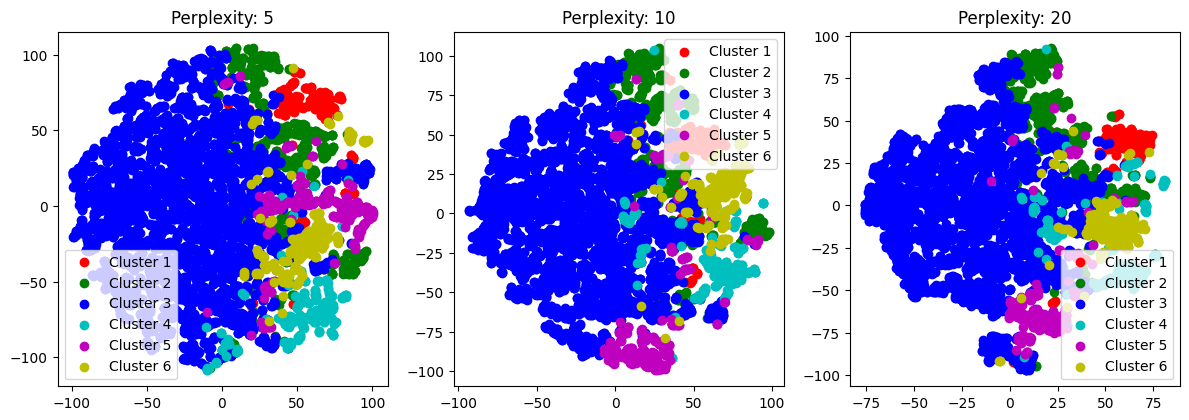

In [14]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# k-means 클러스터링 수행
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(padded_sequences)

# perplexities = [5, 10, 15, 25, 50, 100]
perplexities = [5, 10, 20]

plt.figure(figsize=(12, 8))
for i, perplexity in enumerate(perplexities):
    plt.subplot(2, 3, i + 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_representation = tsne.fit_transform(padded_sequences)

    # 시각화
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for j in range(num_clusters):
        plt.scatter(tsne_representation[cluster_labels == j, 0], tsne_representation[cluster_labels == j, 1], color=colors[j], label=f'Cluster {j+1}')
    plt.title(f'Perplexity: {perplexity}')
    plt.legend()

plt.tight_layout()
plt.show()

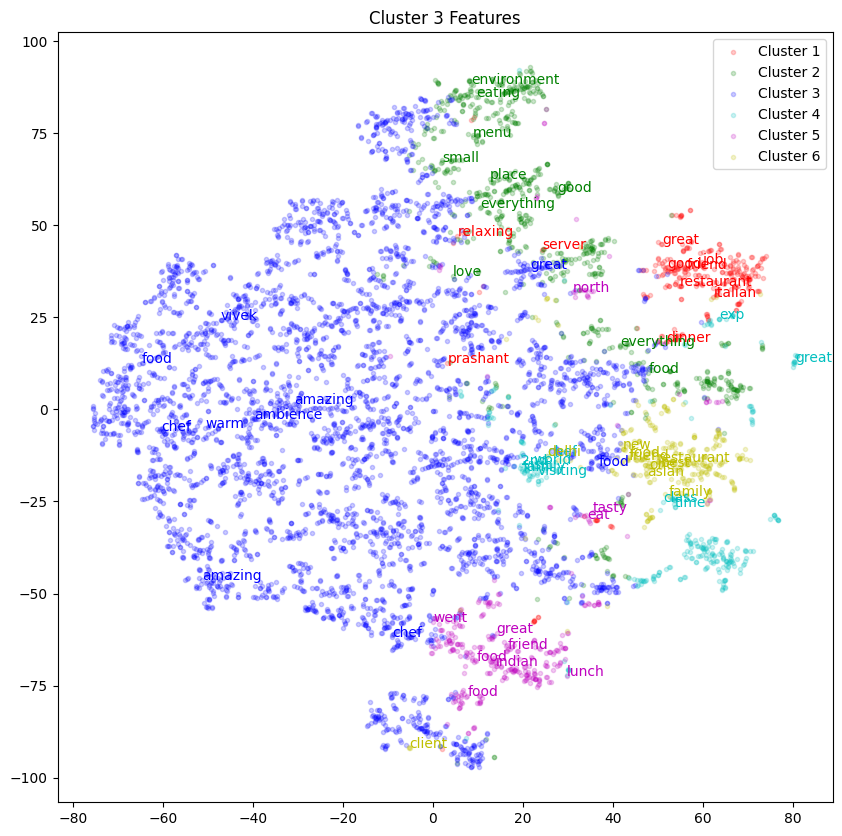

In [15]:
# 선택한 perplexity에 대한 클러스터 특징 확인
selected_perplexity = 5  # 예시로 선택한 perplexity 값
selected_cluster_label = cluster_labels[perplexities.index(selected_perplexity)]

# 선택한 클러스터에 포함된 특징 추출
features = padded_sequences[cluster_labels == selected_cluster_label]

# 특징을 단어로 역추적
reverse_word_index = {index: word for word, index in word_index.items()}
words = [[reverse_word_index.get(index, '') for index in feature] for feature in features]

# 단어를 클러스터 위에 표시
plt.figure(figsize=(10, 10))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    for j in range(min(20, len(cluster_features))):  # 최대 10개 단어만 표시
        plt.text(tsne_representation[cluster_labels == i, 0][j],
                 tsne_representation[cluster_labels == i, 1][j],
                 cluster_features[j],
                 color=colors[i])
    plt.scatter(tsne_representation[cluster_labels == i, 0],
                tsne_representation[cluster_labels == i, 1],
                marker='.',
                c=colors[i],
                alpha=0.2,
                label=f'Cluster {i+1}')
plt.title(f'Cluster {selected_cluster_label + 1} Features')
plt.legend()
plt.show()

In [16]:
import pandas as pd

# 데이터 프레임 초기화
df_clusters = pd.DataFrame(columns=['Cluster', 'Word'])

# 각 클러스터에 대해 데이터 프레임 열 생성
for i in range(num_clusters):
    cluster_features = [word for word in words[i] if word != '']
    cluster_data = pd.DataFrame({'Cluster': [i+1] * len(cluster_features),
                                 'Word': cluster_features})
    df_clusters = pd.concat([df_clusters, cluster_data], ignore_index=True)

# 데이터 프레임 출력
print(df_clusters)

   Cluster         Word
0        1         good
1        1     relaxing
2        1       dinner
3        1      italian
4        1   restaurant
5        1       friend
6        1     prashant
7        1       server
8        1        great
9        1          job
10       2         love
11       2   everything
12       2        place
13       2         menu
14       2         food
15       2  environment
16       2   everything
17       2         good
18       2        small
19       2       eating
20       3        great
21       3     ambience
22       3      amazing
23       3         food
24       3         chef
25       3        vivek
26       3         warm
27       3      amazing
28       3         chef
29       3         food
30       4          2nd
31       4         time
32       4        visit
33       4        great
34       4          exp
35       4     visiting
36       4       family
37       4        world
38       4        class
39       4         chef
40       5      

In [17]:
result = df_clusters.groupby('Cluster')['Word'].apply(list).reset_index()


print(result)

   Cluster                                               Word
0        1  [good, relaxing, dinner, italian, restaurant, ...
1        2  [love, everything, place, menu, food, environm...
2        3  [great, ambience, amazing, food, chef, vivek, ...
3        4  [2nd, time, visit, great, exp, visiting, famil...
4        5  [went, friend, eat, tasty, north, indian, food...
5        6  [one, best, asian, food, restaurant, new, delh...


In [8]:
import pandas as pd

# Create a DataFrame with the word lists for each cluster
cluster_word_lists = []
for i in range(num_clusters):
    cluster_words = df_clusters[df_clusters['Cluster'] == i+1]['Word'].tolist()
    cluster_word_lists.append(cluster_words)

df_word_lists = pd.DataFrame({'Cluster': range(num_clusters), 'Words': cluster_word_lists})

# Display the word lists in a table
print(df_word_lists.iloc[0,:])

for i in df_word_lists.iloc[0,:]:
    print(i)

for i in df_word_lists.iloc[1,:]:
    print(i)

for i in df_word_lists.iloc[2,:]:
    print(i)

for i in df_word_lists.iloc[3,:]:
    print(i)

for i in df_word_lists.iloc[4,:]:
    print(i)

for i in df_word_lists.iloc[5,:]:
    print(i)

Cluster                                                    0
Words      [going, honk, quite, man, falesh, always, top,...
Name: 0, dtype: object
0
['going', 'honk', 'quite', 'man', 'falesh', 'always', 'top', 'job', 'making', 'beautiful', 'cocktail', 'perfection', 'advising', 'best', 'delicacy', 'always', 'remarkable', 'gr8', 'job', 'falesh', 'keep', 'sahil', 'bhalla']
1
['frequent', 'visitor', 'chain', 'year', 'sad', 'restaurant', 'decline', 'seems', 'management', 'completely', 'indifferent', 'unfortunate', 'experience', 'lunch', 'afternoon', 'service', 'poor', 'server', 'bother', 'listen', 'request', 'ordered', 'non', 'spicy', 'vegetarian', 'dish', 'parent', 'eat', 'spicy', 'food', 'dish', 'came', 'different', 'sauce', 'loaded', 'spice', 'server', 'requested', 'accept', 'dish', 'refused', 'could', 'immediately', 'see', 'displeasure', 'overall', 'food', 'average', 'nothing', 'feel', 'good', 'chicken', 'dish', 'tasted', 'stale', 'waste', 'money']
2
['excellent', 'staff', 'cooperative', 